# Text classifier fine-tuning with `simpletransformers`

This notebook shows how to fine-tune a transformer encoder model for text classification with the `simpletransformers` library.

<br>
<a target="_blank" href="https://colab.research.google.com/github/haukelicht/dia_cta_course/blob/main/notebooks/block2/day1/transformer_classifier_finetuning.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# you can ignore this cell
import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# check if on colab
COLAB = True
try:
    import google.colab
except:
    COLAB=False

if COLAB:
    # # shallow clone of current state of main branch 
    # !git clone --branch main --single-branch --depth 1 --filter=blob:none https://github.com/haukelicht/dia_cta_course.git

    !pip install -q simpletransformers==0.70.5

Load the required libraries:

In [3]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split

## Load and preprocess the data

Let's use the data from Fornaciari et al. ([2021](https://doi.org/10.18653/v1/2021.findings-acl.301)).
This dataset contains (English-language) party manifestos sentences.
Each sentence is labeled as either a pledge or not a pledge.
The data was labeled applying Thomson et al.'s' ([2017](https://doi.org/10.1111/ajps.12313), 532) definition:

> [A pledge is] a statement committing a party to one specific action or outcome that can be clearly determined to have occurred or not.

Define the path to the data:

In [4]:
# NOTE: when run locally, we need to adjust the base path to our folder structure
#        currently we are in notebooks/block2/day1/, so we need to go up three levels to the root folder
base_path = Path("/content/dia_cta_course/" if COLAB else "../../../")

data_path = base_path / "data" / "labeled" / "fornaciari_we_2021"

Define the file path and (down)load the data:

In [ ]:
fp = data_path / "fornaciari_we_2021-pledge_binary.tsv"
if not fp.exists():
    # download the data if not present yet
    url = "https://cta-text-datasets.s3.eu-central-1.amazonaws.com/labeled/fornaciari_we_2021/fornaciari_we_2021-pledge_binary.tsv"
    df = pd.read_csv(url, sep="\t")
    fp.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(fp, sep="\t", index=False)

df = pd.read_csv(fp, sep="\t")

Let's inspect the data set by looking at the first few rows:

In [6]:
df.head(3)

,text_id,text,label,metadata__party,metadata__year,metadata__split
0,1,"At the same time, corruption, scams and crime ...",0,BJP,2014,trn
1,2,There has been gross misuse and total denigrat...,0,BJP,2014,trn
2,3,There has also been erosion of authority of th...,0,BJP,2014,trn


As you can see, it records the sentence, its label, and some metadata.

The labels are distributed as follows:

In [7]:
df.label.value_counts()

label
0    4246
1    1417
Name: count, dtype: int64

These numbers indicate 

- `1`: pledge
- `0`: not a pledge

So lets capture this is in a dictionary that maps label classes' names to their numeric IDs and _vice versa_:

In [8]:
id2label = {0: "no pledge", 1: "pledge"}
label2id = {"no pledge": 0, "pledge": 1}

#### Data splitting

In machine learning, we care about developing models that generalize well to new, previously unseen data.
To assess how well a model generalizes, we typically split our labeled data into at least two parts:

- A **training set**: This part of the data is used to train the model.
- A **test set**: This part of the data is held out during training and only used to "evaluate" the model's performance after training.

**Evaluation** in the context of supervised learning refers to the process of measuring the _predictive performance_ of a trained model.
_Predictive_ performance refers to how well the values a model predicts for some inputs aligns with these inputs' actual, "true" values.
In the context of **text classification**, _predictive_ performance therefore focuses on the agreement between the labels a model predicts for documents and their actual, "true" labels.

Evaluation is done in the **test set**.
This dataset contains examples (inputs + labels) that have _not_ been used for training the model.
Because these examples were not used during training, they are referred to as "held-out" or "unseen" examples.

Evaluating a model on held-out examples gives us an idea of how well the model _generalizes_ to new, previously unseen data.
This is important to assess how well it will work when applied to new data.



In the data set we use, the column `metadata__split` already records an indicator of the data split.
Specifically, It indicates that the sentences in the dataset have already been split into two "splits": A training (`trn`) and a development (`dev`) split.

In [9]:
df.metadata__split.value_counts()

metadata__split
trn    5089
dev     574
Name: count, dtype: int64

We will use **the `dev` split as a "test" set** for evaluating its performance after fine-tuning.

In [65]:
df_test = df[df['metadata__split']=='dev']

But for effective model training, we will need an _additional_ data split: the so-called "validation" split.
This will be explained further below.

So we will sample 10% of the examples in the original training into a "validation" split:

In [66]:
df_train = df[df['metadata__split']=='trn']
df_train, df_val = train_test_split(df_train, test_size=0.1, stratify=df_train['label'], random_state=42)

Now, we also keep only the columns relevant for training and evaluation:

In [67]:
cols = ['text', 'label']
df_train = df_train[cols].rename(columns={'text':'text', 'label':'labels'})
df_val = df_val[cols].rename(columns={'text':'text', 'label':'labels'})
# NOTE: we'll keep the metadata columns in the test set for bias analysis later
df_test = df_test.rename(columns={'text':'text', 'label':'labels'})

## Fine-tuning

In the era of large pre-trained language models, fine-tuning has become a crucial step in adapting these models to specific tasks and datasets.

**Fine-tuning** means taking a pre-trained model and training it further on a smaller, task-specific dataset. 

The key idea is that:

1. the pre-trained model has already learned a wealth of linguistic knowledge from vast amounts of text data, and 
2. by fine-tuning it on a specific task, we can adapt this knowledge to perform well on this task. 

In essence, fine-tuning allows us to harness a model's pre-trained capabilities while also learning the nuances of the new task.

**_Note:_**
Fine-tuning relates to *supervised learning*, where training refers to the process of using labeled data to update the parameters of a prediction model.
Labeled data means that for each example in the training data, we know the "true" value of the variable we want to predict.
In classification applications the variable we want to predict is the **class label**.
The goal of this process is to find model parameters that allow the model to make accurate predictions on new, unseen data.
But unlike in classic machine learning, where we train models from scratch, fine-tuning leverages the knowledge already embedded in pre-trained models.



We will proceed in the three steps:

1. Prepare training: 
    - specify (additional) classification performance metrics to compute when evaluating the model
    - Define training arguments that control the fine-tuning process
    - Create the classification model
2. Fine-tune the model on the training data (`df_train`) while monitoring its performance using the validation data (`df_val`)
3. Evaluate the fine-tuned model on the test data (`df_test`)

### Prepare training

#### Evaluation metrics

By default, `simpletransformers` always computes the Mathew's correlation coefficient (MCC) during evaluation for classification tasks.

But we want to monitor additional metrics as well.
So let's define them:

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
extra_metrics_to_compute = dict(
    precision=precision_score,
    recall=recall_score,
    f1=f1_score, 
    ba=balanced_accuracy_score,
)

These metrics are all based on the logic of the **confusion matrix** for binary classification, which cross-tabulates the predicted and actual labels as follows:

- rows: the *actual* ("true") labels of documents
- columns: the *predicted* labels assigned by the classifier

Conceptually, a confusion therefore looks like this, where the labels are "positive" and "negative" refer to the two classes of interest and "positive" represents the class of primary interest (here: _pledges_):

|    _                  | _Predicted_ Positive | _Predicted_ Negative |
| ---------------------:|:--------------------:|:--------------------:|
| **_Actual_ Positive** | True Positive (TP)   | False Negative (FN)  |
| **_Actual_ Negative** | False Positive (FP)  | True Negative (TN)   |

The cells contain the **counts** of documents that fall into each category:

- _True_ **Positives** (TP): correctly predicted positive instances
- _True_ Negatives (TN): correctly predicted negative instances
- _False_ **Positives** (FP): instances predicted as positive that are actually negative
- _False_ Negatives (FN): instances predicted as negative that are actually positive

So for example, the results of a binary classifier applied to 100 test documentscould look like this:

|    _                  | _Predicted_ Positive | _Predicted_ Negative |
| ---------------------:|:--------------------:|:--------------------:|
| **_Actual_ Positive** |  30                  |  10                  |
| **_Actual_ Negative** |  20                  |  40                  |

This would mean that:

- first row (focusing on actual "positive" instances):
    - 30 (out of 40) positive instances were correctly predicted as positive &rArr; these are "true positive" instance (TP)
    - 10 (out of 40) positive instances were _incorrectly_ predicted as negative &rArr; "false negatives" instances (FN)
- second row (focusing on actual "negative" instances):
    - 20 (out of 60) negative instances were _incorrectly_ predicted as positive &rArr; "false positive" instances (FP)
    - 40 (out of 60) negative instances were correctly predicted as negative &rArr; "true negative" instances (TN)


Here is what these metrics measure:

- The **precision** is the share of true positive predictions among all positive predictions made by the model.
    So it tells us in how many of the examples the model labeled as positive instance (here, pledge instances) it was actually correct.
    It is computed as: TP / (TP + FP)
    In the example above, the precision would be 30 / (30 + 20) = 0.6.

- The **recall** is the share of actual positive examples that were correctly identified by the model.
    So it tells us how many of all actual pledge instances the model was able to find.
    It is computed as: TP / (TP + FN).
    In the example above, the recall would be 30 / (30 + 10) = 0.75.

- The **F1 score** combines these metrics into a single value by calculating their harmonic mean.
    It thus provides a balanced summary of precision and recall.
    It is computed as: 2 * (precision * recall) / (precision + recall).
    In the example above, the F1 score would be 2 * (0.6 * 0.75) / (0.6 + 0.75) = 0.6667.

- The **balanced accuracy** is the average of recall obtained on each class.
    So it accounts for class imbalance by giving equal weight to the performance on both classes.
    It is computed as: (TPR + TNR) / 2, where TPR = recall = TP / (TP + FN) and TNR = "specificity" = TN / (TN + FP).
    In the example above, the balanced accuracy would be (0.75 + 0.6667) / 2 = 0.70835.

#### The training arguments

**_Note:_**
For simplicity, all choices are commented directly in the code below.
Refer to the simpletransformers documentation [here](https://simpletransformers.ai/docs/binary-classification/) and [here](https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping) for details.

In [14]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
train_args = ClassificationArgs(
    
    # define a folder (relative to current working directory) to store outputs
    output_dir="outputs/",
    overwrite_output_dir=True,
    
    # main hyperparameters
    num_train_epochs = 5,  # how many times to iterate over the entire training set
    train_batch_size = 16, # how many examples per batch to use during training
    
    # switch on evaluation during training
    evaluate_during_training = True,
    # NOTE 
    #  Evaluation means that the model will be applied to held-out data ("validation" examples).
    #  These examples will be provided below when calling `model.train_model()` method by passing 
    #   our `df_val` data frame to this methods`eval_df` argument.
    #  Based on the examples in these validation examples, we will be able to monitor the model's 
    #   classification performance (e.g. accuracy, f1, etc.) and how it changes during training.
    #  Using held-out data, that is, data that is not used to train the model, allows use to 
    #   compute a realistic estimate of model performance on "unseen" data.
    
    # Let's define some parameters relevant for evaluation:
    evaluate_during_training_steps = 50, # evaluate model after every 50 training steps
    eval_batch_size = 32, # number of examples per batch to use during evaluation
    evaluate_each_epoch = False, # switch off evaluation at the end of each epoch
    
    
    # switch on early stopping
    use_early_stopping = True,
    # NOTE: We use early stopping to avoid overfitting of the model to the  training examples.
    #  Overfitting means that the model learns to classify the training examples very well 
    #   but at the detriment of its ability to generalize to "unseen" (i.e., held-out) data.
    #  With early stopping means to take monitor the model's performance on validation examples
    #   during training (as specified above), and stop training when the performance on the
    #   validation examples stops improving.
    early_stopping_metric = "f1", # what metric to monitor for early stopping?
    early_stopping_delta = 0.015, # how much must this metric improve to be considered an improvement
    early_stopping_metric_minimize = False, # does "impriovement" mean that the metric should decrease?
    early_stopping_patience = 5, # how many evaluation steps to wait for improvement before stopping training?

    manual_seed = 42,
    
    # finally, overwrite some of the default arguments defined by the ClassificationArgs
    no_save = True, # do not save model after training
    save_eval_checkpoints = False, # do not save model checkpoints during evaluation
    save_model_every_epoch = False, # do not save model after each epoch
    no_cache = True, # do not cache data
    use_multiprocessing = False, # do not use multiprocessing for data loading
    use_multiprocessing_for_evaluation = False, # do not use multiprocessing for evaluation data loading
    fp16 = False # do not use mixed precision training
)

We also set **class weights** to account for the ["class imbalance" in the training data](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets).
This can help the classifier to better learn to identify the minority class (here, pledges):

In [15]:
df_train['labels'].value_counts(normalize=True)
# NOTE: only 25% of the training examples are pledges

labels
0    0.748035
1    0.251965
Name: proportion, dtype: float64

To incentivize the model to pay more attention to the minority class (pledges) during training, we assign higher weights to its instances.
In particular, we set the class weights inversely proportional to their frequencies in the training data:
(For technical details, see [here](https://simpletransformers.ai/docs/classification-models/#setting-class-weights-1).)

In [16]:
# compute inverse-proportional class weights
cnts = df_train['labels'].value_counts()
class_weights = cnts.sum()/cnts
class_weights /= class_weights.sum()
class_weights = class_weights.tolist()

### Create the classifier

Now we are ready to create our classifier by 

1. specifying the type and name of the model we want to fine-tune
2. passing the training arguments define above
3. specifying the number of labels

Here, we use the `roberta-base` model.
This model is provided by FacebookAI via the _hugging face_ (FH) model hub: https://huggingface.co/FacebookAI/roberta-base
It is and encoder-only transformer model based on the RoBERTa architecture (Liu et al., [2019](https://arxiv.org/abs/1907.11692)) and pre-trained on a large corpus of English text data.

**_Hint:_** You can see the "type" of a model by inspecting its configuration JSON in the HF hub (e.g., https://huggingface.co/FacebookAI/roberta-base/blob/main/config.json#L15)

In [17]:
# NOTE: a somewhat hard-to-read but up-to-date list of available models is here: https://github.com/ThilinaRajapakse/simpletransformers/tree/master/simpletransformers/classification/transformer_models
model_name = "roberta-base"
classifier = ClassificationModel(
    model_type="roberta", # NOTE: can also set to "custom"
    model_name=model_name,
    args=train_args,
    num_labels=len(id2label),
    weight=class_weights
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**_Note:_** executing the above cell will raise a _warning_ message reading:

```
Some weights ... were not initialized from ...
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
```

This is expected behavior ✅

### Fine-tune

Now we are ready to fine-tune the model.
In `simpletransformers`, this can be done by calling out `classifier`'s `train_model()` method.
In particular, we pass the training data (`df_train`) and the validation data (`df_val`) to this method.
In addition, we pass the dictionary of additional evaluation metrics that should be computed defined above (as `extra_metrics_to_compute`) and use the `**` syntax to unpack this dictionary into keyword arguments.

In [18]:
steps, results = classifier.train_model(df_train, eval_df=df_val, **extra_metrics_to_compute)

/home/hauke-licht/miniforge/envs/dia_cta_course/lib/python3.12/site-packages/simpletransformers/classification/classification_model.py:544: UserWarning: The 'eval_df' parameter has been deprecated and will be removed in a future version. Please use 'eval_data' instead.
  warnings.warn(


Map:   0%|          | 0/4580 [00:00<?, ? examples/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/287 [00:00<?, ?it/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Running Epoch 2 of 5:   0%|          | 0/287 [00:00<?, ?it/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

Map:   0%|          | 0/509 [00:00<?, ? examples/s]

**_Notes:_** 

- That the progress bar showing training progress turns red is _expected behavior_ because we apply **early stopping**.
  It simply indicates that after these many steps, the early stopping criterion was met and training was stopped.
- Depending on your hardware setup, fine-tuning may take a while.

### Examine the training results

Having assigned the output of `classifier.train_model` to `steps` and `results`, we can now inspect the evaluation results computed on the validation set:

In [20]:
val_res = pd.DataFrame(results)
val_res

,global_step,train_loss,mcc,accuracy,f1_score,tp,tn,fp,fn,auroc,auprc,precision,recall,f1,ba,eval_loss
0,50,0.642265,0.419971,0.766208,0.707524,81,309,72,47,0.801120,0.516767,0.529412,0.632812,0.576512,0.721918,0.665712
1,100,0.429108,0.426573,0.768173,0.710617,82,309,72,46,0.824188,0.579369,0.532468,0.640625,0.581560,0.725824,0.536760
2,150,0.511310,0.508871,0.758350,0.728806,109,277,104,19,0.875533,0.695926,0.511737,0.851562,0.639296,0.789298,0.485435
3,200,0.327438,0.492058,0.732809,0.708496,113,260,121,15,0.883817,0.718391,0.482906,0.882812,0.624309,0.782614,0.472456
4,250,0.416241,0.617285,0.836935,0.801922,106,320,61,22,0.895895,0.750827,0.634731,0.828125,0.718644,0.834010,0.457157
5,300,0.175821,0.575406,0.819253,0.780883,102,315,66,26,0.888328,0.726535,0.607143,0.796875,0.689189,0.811823,0.469194
6,350,0.273177,0.623727,0.846758,0.808713,102,329,52,26,0.891015,0.695461,0.662338,0.796875,0.723404,0.830196,0.442851
7,400,0.549697,0.613584,0.846758,0.805245,98,333,48,30,0.893967,0.762133,0.671233,0.765625,0.715328,0.819820,0.515586
8,450,0.928172,0.598156,0.852652,0.798426,85,349,32,43,0.895464,0.780984,0.726496,0.664062,0.693878,0.790036,0.508836
9,500,0.298811,0.626639,0.854617,0.812607,97,338,43,31,0.897945,0.781026,0.692857,0.757812,0.723881,0.822476,0.431636


Plotting the F1 score over training steps shows that it initially increased but then plateaued after some time:

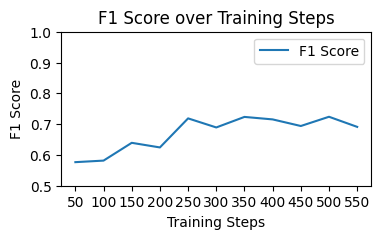

In [38]:
# plot the F1 score over training steps
import matplotlib.pyplot as plt

plt.figure(figsize=(4,2))
plt.plot(val_res['global_step'], val_res['f1'], label='F1 Score')
plt.ylim(0.5, 1)
plt.xlabel('Training Steps')
plt.xticks(val_res['global_step'])
plt.ylabel('F1 Score')
plt.title('F1 Score over Training Steps')
plt.legend()
plt.show()

In [33]:
# when was the best F1 score achieved during training?
int(val_res.global_step[val_res.f1.idxmax()]) # steps

500

It is also a best practice to inspect how the training and validation set loss developped.
Put simply, you want to stop training when the validation loss stops decreasing (or even starts increasing again), as this indicates that the model is beginning to ["overfit"]() the training data.

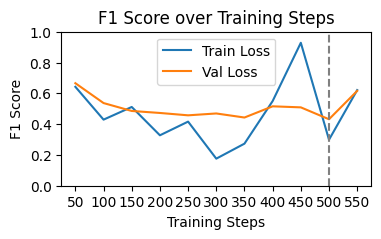

In [37]:
plt.figure(figsize=(4,2))
plt.plot(val_res['global_step'], val_res['train_loss'], label='Train Loss')
plt.plot(val_res['global_step'], val_res['eval_loss'], label='Val Loss')
plt.ylim(0, 1)
# plot vertical line at best F1 score step
plt.axvline(x=int(val_res.global_step[val_res.f1.idxmax()]), color='gray', linestyle='--', label=None)
plt.xlabel('Training Steps')
plt.xticks(val_res['global_step'])
plt.ylabel('F1 Score')
plt.title('F1 Score over Training Steps')
plt.legend()
plt.show()

## Evaluate

Finally, we can evaluate the fine-tuned model on the held-out test set (`df_test`):

In [39]:
eval_res, probs, *_ = classifier.eval_model(df_test, **extra_metrics_to_compute)

Map:   0%|          | 0/574 [00:00<?, ? examples/s]

Running Evaluation:   0%|          | 0/18 [00:00<?, ?it/s]

In [42]:
pd.DataFrame(eval_res, index=['test'])

,mcc,accuracy,f1_score,tp,tn,fp,fn,auroc,auprc,precision,recall,f1,ba,eval_loss
test,0.663212,0.883275,0.830159,93,414,25,42,0.931427,0.815891,0.788136,0.688889,0.735178,0.815971,0.451646


Let's interpret these results:

- The _precision_ of approximately 0.788 indicates that when the model predicts a sentence as a pledge, it is correct about 78% of the time.
- The _recall_ of approximately 0.689 indicates that the model is able to correctly identify about 69% of all actual pledge sentences.
- The ratio of precision to recall is approximately 1.13 and indicates that there is a slightly higher risk of false negatives compared to false positives. This means that the classifier is more likely to miss and actual pledge sentence than to incorrectly label a non-pledge sentence as a pledge.
- The _F1 score_ of approximately 0.735 indicates that the model achieves a good balance between precision and recall in identifying pledge sentences.

### Assessing bias

Bias means that measurement error is systematic.
Systematic how?
Well, this depends on what factors the analyst considers when assessing bias.
Typically, we can use document level metadata that groups documents into different subgroups.
In comparative political research, typical factors are 

- author, speaker, or publisher (e.g., party or newspaper);
- author/speaker characteristics (e.g., ideological leaning, gender, etc.);
- and time (e.g., decade, year, month, or time of day).

One way of assessing bias is to quantify a model's predictive performance by subgroup.
In our data set, the one interesting metadata is the party from whose manifesto the sentence was taken.
So we take this information to group documents by the party:


In [85]:
bias_res = {}
for party, subdf in df_test.groupby("metadata__party"):
    bias_res[party], *_ = classifier.eval_model(subdf, silent=True, **extra_metrics_to_compute)
bias_res_df = pd.DataFrame.from_dict(bias_res)

Map:   0%|          | 0/266 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

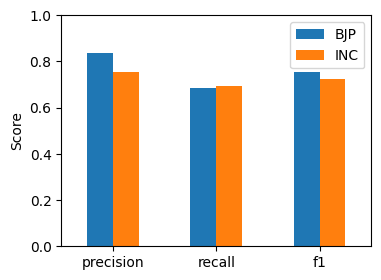

In [87]:
# show precision, recall, and f1 in side-by-side bar plot
bias_res_df.loc[['precision', 'recall', 'f1']].plot.bar(figsize=(4,3))
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xticks(rotation=0) # orient x-axis labels horizontally
plt.show()

This looks fine.

Let's also assess bias by year:

In [88]:
# df_test["metadata__party"]
bias_res = {}
for year, subdf in df_test.groupby("metadata__year"):
    bias_res[year], *_ = classifier.eval_model(subdf, **extra_metrics_to_compute, silent=True)
bias_res_df = pd.DataFrame.from_dict(bias_res)

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/126 [00:00<?, ? examples/s]

Map:   0%|          | 0/132 [00:00<?, ? examples/s]

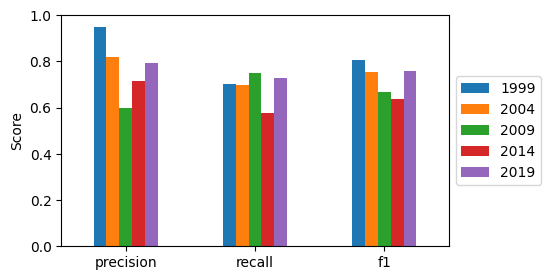

In [94]:
# show precision, recall, and f1 in side-by-side bar plot
bias_res_df.loc[['precision', 'recall', 'f1']].plot.bar(figsize=(5,3))
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xticks(rotation=0) # orient x-axis labels horizontally
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In this case, there are quite some pronounced differences by year.
Contrast, for example, results for 1999 (blue) and 2009 (green):

The recall in these year's manifesto sentences is very similar.
But the classifier's precision is much higher in sentence from 1999 manifestos (0.95 vs. 0.6).
This means that the probablity that the classifier recognizes a sentence as a pledge when it actually is a pledge is about equally high in both years' manifestos.
But the classifier tends to label much more sentences from 2009 manifestos as pledges that are not pledges (and hence has a lower precision) than in manifestos from 1999.
This, in turn, implies that the classifier tends to overestimates the prevalence of pledges more in 2009 manifestos than in 1999 manifestos.

**_Note:_** Problems of bias are the reason why the creators of the dataset we are using also provided the year and party that authored a manifesto sentence as metadata during training (cf. ). 
But this is too advanced for our course 🙂

## Saving a fine-tuned model

If you are happy with the fine-tuned model, you can save it for later use:

In [43]:
model_path = base_path / "models" / (model_name + "-pledge-binary")
classifier.args.no_save = False
classifier.save_model(output_dir=model_path, model=classifier.model)

In [44]:
# clean up
import shutil
shutil.rmtree("outputs/", ignore_errors=True)
shutil.rmtree("runs/", ignore_errors=True)

## Further exercises

1. Go to [the README](./../../../data/labeled/barbera_automated_2021/README.md) of the data directory for the `barbera_automated_2021` data (or view it in [Github](https://github.com/haukelicht/dia_cta_course/tree/main/data/labeled/barbera_automated_2021)).
2. Choose one of the datasets described in it:
    1. choose data set `econ_topic` if you want to stick to text _classification_
    2. choose data set `econ_sentiment` if you want to try out text _regression_ (more advanced)

Note that for option 2.2 (regression), you also need to:

1. read about how to create a regression model in `simpletransformers` [here](https://simpletransformers.ai/docs/regression/), and
2. read about evaluation metrics for regression [here](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).